In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# ADE20K

Sky is rgb = (90 116 26) in label png


label is computed as  ObjectClassMasks = (R/10).astype(np.int32)*256+(G.astype(np.int32)) 

sky label is 2420


In [102]:
class PILToTensor:
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

In [104]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import functional as F
import cv2

torch.manual_seed(17)


class SegmentationDataset(Dataset):
    def __init__(self, folder_path, geometricTransform=None, colorTransform=None):
        self.img_files = glob.glob(os.path.join(folder_path,'**/**/*.jpg'))
        self.mask_files = []
        self.geometricTransform = geometricTransform
        self.colorTransform = colorTransform
        for img_path in self.img_files:
            self.mask_files.append(os.path.splitext(img_path)[0] + "_seg.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = Image.open(img_path)
            label = Image.open(mask_path)
            if self.colorTransform:
                image = self.colorTransform(image)
            if self.geometricTransform:
                image = self.geometricTransform(image) 
                label = self.geometricTransform(label)

            return PILToTensor()(image, label)

    def __len__(self):
        return len(self.img_files)

In [105]:
from torchvision import datasets, transforms

geometricTransforms = transforms.Compose([
    transforms.Resize((255,255)),
                               ])

colorTransforms = transforms.Compose([
    transforms.ColorJitter(brightness=.1, hue=.05),                                      
                               ])


segmentationDataset = SegmentationDataset('/home/cstrauss/DATASETS/stra0059_8cd367f/ADE20K_2021_17_01/images/ADE/training/', geometricTransforms, colorTransforms)
len(segmentationDataset)

25574

In [106]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(segmentationDataset, batch_size=5, shuffle=True)


Feature batch shape: torch.Size([5, 3, 255, 255])
Labels batch shape: torch.Size([5, 255, 255, 3])


<Figure size 800x1000 with 0 Axes>

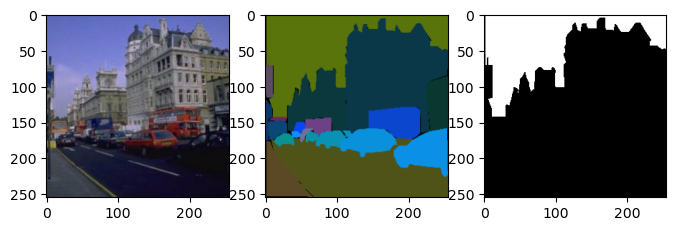

In [152]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0].squeeze()

#img, label = segmentationDataset[0]
#img = img.permute(1, 2, 0)
#label = label.squeeze()
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(label, cmap="gray")

R = label[:,:,0].numpy()
G = label[:,:,1].numpy()
B = label[:,:,2].numpy()
ObjectClassMasks = (R/10).astype(np.int32)*256+(G.astype(np.int32));

mask = np.zeros((label.shape[0],label.shape[1]))

m = ObjectClassMasks == 2420
mask[m] = 255
axarr[2].imshow(mask, cmap="gray")



In [18]:
from PIL import Image
import glob
import os
import numpy as np
import cv2
from tqdm import tqdm

folder_path = '/home/cstrauss/DATASETS/stra0059_8cd367f/ADE20K_2021_17_01/images/ADE/training/'

binary_mask_output_folder = './ADE20kSky'
sky_class_id = 2420

try:
    os.mkdir(binary_mask_output_folder)
except OSError as error:
    print(error)

img_files = glob.glob(os.path.join(folder_path, '**/**/*.jpg'))
mask_files = []

with tqdm(total=len(img_files)) as pbar:
    for img_path in img_files:
        pbar.update(1)
        mask_path = os.path.splitext(img_path)[0] + "_seg.png"
        image = Image.open(img_path)
        image_name = os.path.basename(img_path)
        try:
            # simlink rgb image into the same folder, eveythings in one place
            #print(img_path, os.path.abspath(os.path.join(folder_path, image_name)))
            os.symlink(os.path.abspath(img_path), os.path.abspath(
                os.path.join(binary_mask_output_folder, image_name)))
        except OSError as error:
            print(error)

        label = np.array(Image.open(mask_path))

        R = label[:, :, 0]
        G = label[:, :, 1]
        B = label[:, :, 2]

        ObjectClassMasks = (R/10).astype(np.int32)*256+(G.astype(np.int32))

        mask = np.zeros((label.shape[0], label.shape[1]))

        m = ObjectClassMasks == sky_class_id
        mask[m] = 255

        maskPath = binary_mask_output_folder + '/' + image_name + '_skyMask.png'
        # mask = Image.fromarray(mask)
        # mask.save(maskPath)
        cv2.imwrite(maskPath, mask)

    #print(" saved " + maskPath)


# print(img_files)


[Errno 17] File exists: './ADE20kSky'


  0%|          | 0/25574 [00:00<?, ?it/s]

[Errno 17] File exists: '/home/cstrauss/DATASETS/stra0059_8cd367f/ADE20K_2021_17_01/images/ADE/training/nature_landscape/boardwalk/ADE_train_00022896.jpg' -> '/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/ADE20kSky/ADE_train_00022896.jpg'


100%|██████████| 25574/25574 [09:15<00:00, 46.03it/s] 
